In [1]:
import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"
import matplotlib.pyplot as plt

%matplotlib qt

import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from mne.time_frequency import psd_array_multitaper
import os
from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()


mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

# Assuming EEG data is in MNE format (Epochs or Raw). Placeholder for file path to participants' data
data_dir = "path_to_data"

# Frequency bands definitions
freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}

# Placeholder for results
results = []


In [2]:
import os
import mne

def load_participant_epochs(pnum, condition):
    """Load and concatenate epochs for a participant across multiple blocks for a given condition.
    
    Parameters:
    - pnum: Participant number (integer)
    - condition: Condition (e.g., 'D' or 'ND')
    
    Returns:
    - concatenated_epochs: Concatenated MNE epochs object for the participant
    """
    
    # Initialize an empty list to store the epochs from each block
    epochs_list = []
    
    # Loop through all 4 blocks
    for b_cnt in range(0, 4):
        # Create the block numbers by appending the current block count to the condition
        block_num = f"{condition}{b_cnt}"
        
        # Construct the participant's folder name
        participant_number = 'P' + str(pnum)
        # Create the full path to the epochs file
        participant_data_path = participant_number + '/' + block_num + '-epo.fif'
        path = os.path.join(configss['root'], configss['data_dir'], participant_data_path)
        
        # Load the epochs file for this block
        epochs = mne.read_epochs(path, preload=True)
        
        # Append the loaded epochs to the list
        epochs_list.append(epochs)
    
    # Concatenate all the loaded epochs from the list
    concatenated_epochs = mne.concatenate_epochs(epochs_list)
    
    return concatenated_epochs


In [ ]:
#anova

import numpy as np
import pandas as pd
from scipy.stats import shapiro
import pingouin as pg  # For repeated measures ANOVA
from statsmodels.stats.multitest import multipletests  # For p-value correction

valid_pids = [el for el in list(range(1, 32)) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# Modified code to include 'channel' column when collecting data for each specific channel
all_data = []

for participant_id in valid_pids:
    # Load epochs for both conditions
    epochs_condition_D = load_participant_epochs(participant_id, 'D')
    epochs_condition_ND = load_participant_epochs(participant_id, 'ND')

    channels = epochs_condition_D.ch_names  # List of channel names
    sfreq = epochs_condition_D.info['sfreq']  # Sampling frequency

    # Get data arrays for both conditions (n_epochs, n_channels, n_times)
    data_D = epochs_condition_D.get_data()
    data_ND = epochs_condition_ND.get_data()

    for band_name, (fmin, fmax) in freq_bands.items():
        psds_D = []
        psds_ND = []
        # Compute PSD for each epoch in condition D
        for epoch_data in data_D:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_D.append(psd)
        # Compute PSD for each epoch in condition ND
        for epoch_data in data_ND:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_ND.append(psd)

        psds_D = np.array(psds_D)  # Shape: (n_epochs, n_channels, n_freqs)
        psds_ND = np.array(psds_ND)

        psds_mean_freq_D = np.mean(psds_D, axis=-1)  # Shape: (n_epochs, n_channels)
        psds_mean_freq_ND = np.mean(psds_ND, axis=-1)

        # Compute Mean PSD Across Epochs
        psds_mean_D = np.mean(psds_mean_freq_D, axis=0)    # Shape: (n_channels,)
        psds_mean_ND = np.mean(psds_mean_freq_ND, axis=0)  # Shape: (n_channels,)

        # Collect data into a DataFrame for each channel
        for ch_idx, channel_name in enumerate(channels):
            df_D = pd.DataFrame({
                'participant': [participant_id],
                'condition': ['D'],
                'band': [band_name],
                'channel': [channel_name],
                'power': [psds_mean_D[ch_idx]]
            })

            df_ND = pd.DataFrame({
                'participant': [participant_id],
                'condition': ['ND'],
                'band': [band_name],
                'channel': [channel_name],
                'power': [psds_mean_ND[ch_idx]]
            })

            all_data.append(df_D)
            all_data.append(df_ND)

# Concatenate all data into a single DataFrame with the correct 'channel' column
data_df = pd.concat(all_data, ignore_index=True)

# --- Shapiro-Wilk Normality Test ---
normal = True
for band_name in freq_bands.keys():
    for ch_name in data_df['channel'].unique():
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()
        if len(pivot_df) < 1:
            continue
        
        # Shapiro-Wilk test on average power values for 'D' and 'ND' conditions
        stat_D, p_value_D = shapiro(pivot_df['D'])
        stat_ND, p_value_ND = shapiro(pivot_df['ND'])
        
        if p_value_D < 0.05 or p_value_ND < 0.05:
            normal = False

# If not all data is normally distributed, apply log transformation
if not normal:
    print("Non-normal distribution detected. Applying log transformation.")
    data_df['power'] = np.log1p(data_df['power'])

# --- Repeated Measures ANOVA ---
results = []
for band_name in freq_bands.keys():
    for ch_name in data_df['channel'].unique():
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()

        if len(pivot_df) < 1:
            continue

        # Perform repeated measures ANOVA
        subset_melted = pd.melt(pivot_df.reset_index(), id_vars='participant', value_vars=['D', 'ND'], var_name='condition', value_name='power')
        aov = pg.rm_anova(dv='power', within='condition', subject='participant', data=subset_melted, detailed=True)

        # Extract F-statistic, p-value, degrees of freedom, and effect size
        f_stat = aov['F'][0]
        p_value = aov['p-unc'][0]
        df = aov['DF'][0]  # Degrees of freedom for the effect
        effect_size = aov['ng2'][0]  # Partial eta squared

        results.append({
            'band': band_name,
            'channel': ch_name,
            'F_stat': f_stat,
            'p_value': p_value,
            'degrees_of_freedom': df,
            'effect_size': effect_size
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('tfr_group_level_anova_results.csv', index=False)

print("Repeated measures ANOVA complete.")


In [5]:
results = []
for band_name in freq_bands.keys():
    for ch_name in data_df['channel'].unique():
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()

        if len(pivot_df) < 1:
            continue

        # Perform repeated measures ANOVA
        subset_melted = pd.melt(pivot_df.reset_index(), id_vars='participant', value_vars=['D', 'ND'], var_name='condition', value_name='power')
        aov = pg.rm_anova(dv='power', within='condition', subject='participant', data=subset_melted, detailed=True)

        # Extract F-statistic, p-value, degrees of freedom, and effect size
        f_stat = aov['F'][0]
        p_value = aov['p-unc'][0]
        df = aov['DF'][0]  # Degrees of freedom for the effect
        effect_size = aov['ng2'][0]  # Partial eta squared

        results.append({
            'band': band_name,
            'channel': ch_name,
            'F_stat': f_stat,
            'p_value': p_value,
            'degrees_of_freedom': df,
            'effect_size': effect_size
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('tfr_group_level_anova_results.csv', index=False)

print("Repeated measures ANOVA complete.")


Repeated measures ANOVA complete.


In [ ]:
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests  # Import for p-value correction

valid_pids = [el for el in list(range(1, 32)) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# Modified code to include 'channel' column when collecting data for each specific channel
all_data = []

for participant_id in valid_pids:
    # Load epochs for both conditions
    epochs_condition_D = load_participant_epochs(participant_id, 'D')
    epochs_condition_ND = load_participant_epochs(participant_id, 'ND')

    channels = epochs_condition_D.ch_names  # List of channel names
    sfreq = epochs_condition_D.info['sfreq']  # Sampling frequency

    # Get data arrays for both conditions (n_epochs, n_channels, n_times)
    data_D = epochs_condition_D.get_data()
    data_ND = epochs_condition_ND.get_data()

    for band_name, (fmin, fmax) in freq_bands.items():
        psds_D = []
        psds_ND = []
        # Compute PSD for each epoch in condition D
        for epoch_data in data_D:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_D.append(psd)
        # Compute PSD for each epoch in condition ND
        for epoch_data in data_ND:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_ND.append(psd)

        psds_D = np.array(psds_D)  # Shape: (n_epochs, n_channels, n_freqs)
        psds_ND = np.array(psds_ND)

        psds_mean_freq_D = np.mean(psds_D, axis=-1)  # Shape: (n_epochs, n_channels)
        psds_mean_freq_ND = np.mean(psds_ND, axis=-1) 

        # --- Step 3: Z-Score Normalization for Condition D ---
        mean_D = np.mean(psds_mean_freq_D, axis=0)  # Shape: (n_channels,)
        std_D = np.std(psds_mean_freq_D, axis=0)    # Shape: (n_channels,)
        std_D[std_D == 0] = 1e-15                     # Prevent division by zero
        psds_mean_freq_D_norm = (psds_mean_freq_D - mean_D) / std_D  # Normalized

        # --- Step 4: Z-Score Normalization for Condition ND ---
        mean_ND = np.mean(psds_mean_freq_ND, axis=0)  # Shape: (n_channels,)
        std_ND = np.std(psds_mean_freq_ND, axis=0)    # Shape: (n_channels,)
        std_ND[std_ND == 0] = 1e-15                     # Prevent division by zero
        psds_mean_freq_ND_norm = (psds_mean_freq_ND - mean_ND) / std_ND  # Normalized

        # --- Step 5: Compute Mean Normalized PSD Across Epochs ---
        psds_mean_D_norm = np.mean(psds_mean_freq_D_norm, axis=0)    # Shape: (n_channels,)
        psds_mean_ND_norm = np.mean(psds_mean_freq_ND_norm, axis=0)  # Shape: (n_channels,)

        # Collect data into a DataFrame for each channel
        for ch_idx, channel_name in enumerate(channels):
            df_D = pd.DataFrame({
                'participant': [participant_id],  # Wrap scalar values in lists
                'condition': ['D'],
                'band': [band_name],
                'channel': [channel_name],
                'power': [psds_mean_D_norm[ch_idx]]  # Wrap the power value in a list
            })

            df_ND = pd.DataFrame({
                'participant': [participant_id],  # Wrap scalar values in lists
                'condition': ['ND'],
                'band': [band_name],
                'channel': [channel_name],
                'power': [psds_mean_ND_norm[ch_idx]]  # Wrap the power value in a list
            })

            all_data.append(df_D)
            all_data.append(df_ND)


# Concatenate all data into a single DataFrame with the correct 'channel' column
data_df = pd.concat(all_data, ignore_index=True)


# Now, rerun the statistical analysis with the updated DataFrame
results = []
channels = data_df['channel'].unique()  # Get unique channels from the DataFrame
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        # Pivot the data to have one column per condition
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()
        if len(pivot_df) < 1:
            continue
        # Wilcoxon signed-rank test
        try:
            stat, p_value = wilcoxon(pivot_df['D'], pivot_df['ND'])
        except ValueError as e:
            stat, p_value = np.nan, np.nan
        results.append({
            'band': band_name,
            'channel': ch_name,
            'statistic': stat,
            'p_value': p_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('tfr_group_level_wilcoxon_results_normalized.csv', index=False)

print("Wilcoxon statistical analysis complete on normalized data.")

In [5]:
try:
    results_df.to_csv('group_level_normalized_psd_tfr_data.csv', index=False)
    print("Results saved successfully.")
except NameError:
    print("The DataFrame 'results_df' is not defined in the current environment.")

Results saved successfully.


In [48]:
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests  # Import for p-value correction

valid_pids = [el for el in list(range(1, 32)) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# Modified code to include 'channel' column when collecting data for each specific channel
all_data = []

for participant_id in valid_pids:
    # Load epochs for both conditions
    epochs_condition_D = load_participant_epochs(participant_id, 'D')
    epochs_condition_ND = load_participant_epochs(participant_id, 'ND')

    channels = epochs_condition_D.ch_names  # List of channel names
    sfreq = epochs_condition_D.info['sfreq']  # Sampling frequency

    # Get data arrays for both conditions (n_epochs, n_channels, n_times)
    data_D = epochs_condition_D.get_data()
    data_ND = epochs_condition_ND.get_data()

    for band_name, (fmin, fmax) in freq_bands.items():
        psds_D = []
        psds_ND = []
        # Compute PSD for each epoch in condition D
        for epoch_data in data_D:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_D.append(psd)
        # Compute PSD for each epoch in condition ND
        for epoch_data in data_ND:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_ND.append(psd)

        psds_D = np.array(psds_D)  # Shape: (n_epochs, n_channels, n_freqs)
        psds_ND = np.array(psds_ND)

        psds_mean_freq_D = np.mean(psds_D, axis=-1)  # Shape: (n_epochs, n_channels)
        psds_mean_freq_ND = np.mean(psds_ND, axis=-1) 

        # psds_mean_freq_D_log = np.log(psds_mean_freq_D)
        # psds_mean_freq_ND_log = np.log(psds_mean_freq_ND)

        # --- Step 3: Z-Score Normalization for Condition D ---
        mean_D = np.mean(psds_mean_freq_D, axis=0)  # Shape: (n_channels,)
        std_D = np.std(psds_mean_freq_D, axis=0)    # Shape: (n_channels,)
        std_D[std_D == 0] = 1e-15                     # Prevent division by zero
        psds_mean_freq_D_norm = (psds_mean_freq_D - mean_D) / std_D  # Normalized

        # --- Step 4: Z-Score Normalization for Condition ND ---
        mean_ND = np.mean(psds_mean_freq_ND, axis=0)  # Shape: (n_channels,)
        std_ND = np.std(psds_mean_freq_ND, axis=0)    # Shape: (n_channels,)
        std_ND[std_ND == 0] = 1e-15                     # Prevent division by zero
        psds_mean_freq_ND_norm = (psds_mean_freq_ND - mean_ND) / std_ND  # Normalized

        # # --- Step 5: Compute Mean Normalized PSD Across Epochs ---
        psds_mean_D_norm = np.mean(psds_mean_freq_D_norm, axis=0)    # Shape: (n_channels,)
        psds_mean_ND_norm = np.mean(psds_mean_freq_ND_norm, axis=0)  # Shape: (n_channels,)

        # Collect data into a DataFrame for each channel
        for ch_idx, channel_name in enumerate(channels):
            df_D = pd.DataFrame({
                'participant': [participant_id],  # Wrap scalar values in lists
                'condition': ['D'],
                'band': [band_name],
                'channel': [channel_name],
                'power': [psds_mean_D_norm[ch_idx]]  # Wrap the power value in a list
            })

            df_ND = pd.DataFrame({
                'participant': [participant_id],  # Wrap scalar values in lists
                'condition': ['ND'],
                'band': [band_name],
                'channel': [channel_name],
                'power': [psds_mean_ND_norm[ch_idx]]  # Wrap the power value in a list
            })

            all_data.append(df_D)
            all_data.append(df_ND)


# Concatenate all data into a single DataFrame with the correct 'channel' column
data_df = pd.concat(all_data, ignore_index=True)

# Assuming data_df is already available and includes the 'channel' column
# Function to get band average for a specific channel
def get_band_average_channel(data_df, band_name, condition, channel_name):
    subset = data_df[(data_df['band'] == band_name) & (data_df['condition'] == condition) & (data_df['channel'] == channel_name)]
    participant_averages = subset.groupby('participant')['power'].mean().values
    return participant_averages

# Specify the channel name of interest
channel_name = '6Z'  # Replace with the desired channel name

# Use the actual data to retrieve averages for theta, alpha, and beta bands for condition D for a specific channel
theta_D_channel = get_band_average_channel(data_df, 'theta', 'D', channel_name)
alpha_D_channel = get_band_average_channel(data_df, 'alpha', 'D', channel_name)
beta_D_channel = get_band_average_channel(data_df, 'beta', 'D', channel_name)

# Use the actual data to retrieve averages for theta, alpha, and beta bands for condition ND for the same channel
theta_ND_channel = get_band_average_channel(data_df, 'theta', 'ND', channel_name)
alpha_ND_channel = get_band_average_channel(data_df, 'alpha', 'ND', channel_name)
beta_ND_channel = get_band_average_channel(data_df, 'beta', 'ND', channel_name)

# Create a 3D scatter plot using the actual data for the specified channel
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot for Condition D
ax.scatter(theta_D_channel, alpha_D_channel, beta_D_channel, color='b', label='D', s=60)

# Plot for Condition ND
ax.scatter(theta_ND_channel, alpha_ND_channel, beta_ND_channel, color='r', label='ND', s=60)

# Set labels
ax.set_xlabel('Theta Band Power')
ax.set_ylabel('Alpha Band Power')
ax.set_zlabel('Beta Band Power')
ax.set_title(f'3D Scatter Plot of Band Power for Each Participant (D and ND) - Channel: {channel_name}')

# Add legend
ax.legend()

plt.show()



C:\Users\erangad\AppData\Local\Temp\ipykernel_14596\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_14596\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_14596\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_14596\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Function to plot the topographic maps for each condition and frequency band
def plot_psd_topomap(data_df, freq_bands, epochs_condition1):
    channel_names = epochs_condition1.ch_names  # Get channel names from the epochs object

    # Iterate over each frequency band
    for band_name in freq_bands.keys():
        # Initialize average power arrays for the 'D' and 'ND' conditions
        avg_power_D = np.zeros(len(channel_names))
        avg_power_ND = np.zeros(len(channel_names))

        # Iterate over channels to compute the average power for each condition
        for ch_idx, ch_name in enumerate(channel_names):
            # Get average power for 'D' condition
            avg_power_D[ch_idx] = data_df[(data_df['band'] == band_name) & 
                                          (data_df['condition'] == 'D') & 
                                          (data_df['channel'] == ch_name)]['power'].mean()

            # Get average power for 'ND' condition
            avg_power_ND[ch_idx] = data_df[(data_df['band'] == band_name) & 
                                           (data_df['condition'] == 'ND') & 
                                           (data_df['channel'] == ch_name)]['power'].mean()

        # Create the plots for both conditions
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        info = epochs_condition1.info.copy()
        info['bads'] = []  # Clear any bad channels

        # Plot 'D' condition topomap
        mne.viz.plot_topomap(
            avg_power_D, info, axes=axes[0], cmap='viridis', 
             names=channel_names, show=False,
            contours=0, sphere=(0.00, -0.02, 0.005, 0.13)
        )
        axes[0].set_title(f'{band_name.capitalize()} Band - D Condition')

        # Plot 'ND' condition topomap
        mne.viz.plot_topomap(
            avg_power_ND, info, axes=axes[1], cmap='viridis', 
            names=channel_names, show=False,
            contours=0, sphere=(0.00, -0.02, 0.005, 0.13)
        )
        axes[1].set_title(f'{band_name.capitalize()} Band - ND Condition')

        # Add colorbar
        cbar = fig.colorbar(axes[0].images[0], ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
        cbar.set_label('Normalized Power')

        # Show the plot
        plt.suptitle(f'Topomap of Average Power - {band_name.capitalize()} Band')
        plt.show()

# Example usage (assuming `data_df`, `freq_bands`, and `epochs_condition1` are already defined)
plot_psd_topomap(data_df, freq_bands, epochs_condition1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Function to plot the topographic maps for the average power across all frequency bands for each condition
def plot_average_power_topomap(data_df, epochs_condition1):
    channel_names = epochs_condition1.ch_names  # Get channel names from the epochs object

    # Initialize arrays for the average power across all bands for the 'D' and 'ND' conditions
    avg_power_D = np.zeros(len(channel_names))
    avg_power_ND = np.zeros(len(channel_names))

    # Iterate over each channel to compute the average power across all bands
    for ch_idx, ch_name in enumerate(channel_names):
        # Compute the average power across all bands for 'D' condition
        avg_power_D[ch_idx] = data_df[(data_df['condition'] == 'D') & 
                                      (data_df['channel'] == ch_name)]['power'].mean()

        # Compute the average power across all bands for 'ND' condition
        avg_power_ND[ch_idx] = data_df[(data_df['condition'] == 'ND') & 
                                       (data_df['channel'] == ch_name)]['power'].mean()

    # Create the plots for both conditions
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    info = epochs_condition1.info.copy()
    info['bads'] = []  # Clear any bad channels

    # Plot 'D' condition topomap
    mne.viz.plot_topomap(
        avg_power_D, info, axes=axes[0], cmap='viridis', names=channel_names, show=False,
        contours=0, sphere=(0.00, -0.02, 0.005, 0.13)
    )
    axes[0].set_title('Average Power - D Condition')

    # Plot 'ND' condition topomap
    mne.viz.plot_topomap(
        avg_power_ND, info, axes=axes[1], cmap='viridis', 
         names=channel_names, show=False,
        contours=0, sphere=(0.00, -0.02, 0.005, 0.13)
    )
    axes[1].set_title('Average Power - ND Condition')

    # Add colorbar
    cbar = fig.colorbar(axes[0].images[0], ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
    cbar.set_label('Normalized Power')

    # Show the plot
    plt.suptitle('Topomap of Average Power Across All Bands')
    plt.show()

# Example usage (assuming `data_df` and `epochs_condition1` are already defined)
plot_average_power_topomap(data_df, epochs_condition1)


In [9]:
try:
    results_df.to_csv('group_level_normalized_psd_tfr_data.csv', index=False)
    print("Results saved successfully.")
except NameError:
    print("The DataFrame 'results_df' is not defined in the current environment.")

Results saved successfully.


In [46]:
data_df = pd.read_csv("group_level_normalized_psd_tfr_data.csv")

In [57]:
# Assuming data_df is already available and includes the 'channel' column
# Function to get band average for a specific channel
def get_band_average_channel(data_df, band_name, condition, channel_name):
    subset = data_df[(data_df['band'] == band_name) & (data_df['condition'] == condition) & (data_df['channel'] == channel_name)]
    participant_averages = subset.groupby('participant')['power'].mean().values
    return participant_averages

# Specify the channel name of interest
channel_name = '1LD'  # Replace with the desired channel name

# Use the actual data to retrieve averages for theta, alpha, and beta bands for condition D for a specific channel
theta_D_channel = get_band_average_channel(data_df, 'theta', 'D', channel_name)
alpha_D_channel = get_band_average_channel(data_df, 'alpha', 'D', channel_name)
beta_D_channel = get_band_average_channel(data_df, 'beta', 'D', channel_name)

# Use the actual data to retrieve averages for theta, alpha, and beta bands for condition ND for the same channel
theta_ND_channel = get_band_average_channel(data_df, 'theta', 'ND', channel_name)
alpha_ND_channel = get_band_average_channel(data_df, 'alpha', 'ND', channel_name)
beta_ND_channel = get_band_average_channel(data_df, 'beta', 'ND', channel_name)

# Create a 3D scatter plot using the actual data for the specified channel
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot for Condition D
ax.scatter(theta_D_channel, alpha_D_channel, beta_D_channel, color='b', label='D', s=60)

# Plot for Condition ND
ax.scatter(theta_ND_channel, alpha_ND_channel, beta_ND_channel, color='r', label='ND', s=60)

# Set labels
ax.set_xlabel(r"$\dot{\theta}$ band power")
ax.set_ylabel(r"$\dot{\alpha}$ band power")
ax.set_zlabel(r"$\dot{\beta}$ band power")
ax.set_title(f'3D Scatter Plot of Band Power for Each Participant (D and ND) - Channel: {channel_name}')

# Add legend
ax.legend()

plt.show()


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming data_df is already available and contains the power values for all participants
# Filter data for the theta, alpha, and beta bands and group by participant and condition
def get_band_average(data_df, band_name, condition):
    subset = data_df[(data_df['band'] == band_name) & (data_df['condition'] == condition)]
    participant_averages = subset.groupby('participant')['power'].mean().values
    return participant_averages

# Use the actual data to retrieve averages for theta, alpha, and beta bands for both conditions
theta_D = get_band_average(data_df, 'theta', 'D')
alpha_D = get_band_average(data_df, 'alpha', 'D')
beta_D = get_band_average(data_df, 'beta', 'D')

theta_ND = get_band_average(data_df, 'theta', 'ND')
alpha_ND = get_band_average(data_df, 'alpha', 'ND')
beta_ND = get_band_average(data_df, 'beta', 'ND')

# Create a 3D scatter plot using the actual data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot for Condition D
ax.scatter(theta_D, alpha_D, beta_D, color='b', label='D', s=60)

# Plot for Condition ND
ax.scatter(theta_ND, alpha_ND, beta_ND, color='r', label='ND', s=60)

# Set labels
ax.set_xlabel('Theta Band Power')
ax.set_ylabel('Alpha Band Power')
ax.set_zlabel('Beta Band Power')
ax.set_title('3D Scatter Plot of Band Power for Each Participant (D and ND)')

# Add legend
ax.legend()

plt.show()


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# Assuming all_data and data_df are already created as per your script

# Now perform statistical tests for each channel and band across all participants
results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        # Pivot the data to have one column per condition
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()
        if len(pivot_df) < 1:
            continue
        # Paired t-test
        try:
            stat, p_value = ttest_rel(pivot_df['D'], pivot_df['ND'])
            # Calculate Cohen's d
            mean_diff = pivot_df['D'] - pivot_df['ND']
            cohen_d = mean_diff.mean() / mean_diff.std(ddof=1)
        except ValueError as e:
            stat, p_value, cohen_d = np.nan, np.nan, np.nan
        results.append({
            'band': band_name,
            'channel': ch_name,
            't_statistic': stat,
            'p_value': p_value,
            'cohen_d': cohen_d
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons using FDR
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('PSD_group_level_ttest_results_with_effect_sizes.csv', index=False)

print("Paired t-test statistical analysis complete on normalized data.")


NameError: name 'freq_bands' is not defined

In [26]:
import matplotlib.pyplot as plt

# Choose a channel index (e.g., channel 0)
channel_idx = 0

# Plot histograms for Condition D and ND
plt.figure(figsize=(12, 6))

# Condition D
plt.subplot(1, 2, 1)
plt.hist(psds_mean_freq_D_norm[:, channel_idx], bins=30, color='blue', alpha=0.7)
plt.title(f'Condition D - Channel {channel_idx} Normalized PSD')
plt.xlabel('Normalized PSD')
plt.ylabel('Frequency')

# Condition ND
plt.subplot(1, 2, 2)
plt.hist(psds_mean_freq_ND_norm[:, channel_idx], bins=30, color='green', alpha=0.7)
plt.title(f'Condition ND - Channel {channel_idx} Normalized PSD')
plt.xlabel('Normalized PSD')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [5]:
psds_mean_ND.shape  # with one band

(62,)

In [3]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# List of valid participant IDs
valid_pids = [el for el in range(1, 32) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Initialize dictionary to store significant channels per participant per band
significant_channels_per_band = {band: {} for band in freq_bands.keys()}


# Function to perform time-frequency analysis using multitaper with per-participant p-value corrections
def time_frequency_analysis_multitaper_per_participant(epochs_condition1, epochs_condition2, freq_bands, participant_id):
    results = []
    channels = epochs_condition1.ch_names  # List of channel names
    sfreq = epochs_condition1.info['sfreq']  # Sampling frequency

    data_c1 = epochs_condition1.get_data()  # Shape: (n_epochs, n_channels, n_times)
    data_c2 = epochs_condition2.get_data()

    for band_name, (fmin, fmax) in freq_bands.items():
        psds_c1 = []
        psds_c2 = []
        # Compute PSD for each epoch in condition 1
        for epoch_data in data_c1:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_c1.append(psd)
        # Compute PSD for each epoch in condition 2
        for epoch_data in data_c2:
            psd, freqs = psd_array_multitaper(
                epoch_data, sfreq, fmin=fmin, fmax=fmax, bandwidth=None,
                adaptive=True, low_bias=True, normalization='full', verbose=False)
            psds_c2.append(psd)
        # Convert to NumPy arrays
        psds_c1 = np.array(psds_c1)  # Shape: (n_epochs, n_channels, n_freqs)
        psds_c2 = np.array(psds_c2)
        # Average over frequency band
        psds_mean_c1 = psds_c1.mean(axis=-1)  # Shape: (n_epochs, n_channels)
        psds_mean_c2 = psds_c2.mean(axis=-1)
        
        # Perform statistical testing per channel
        p_values = []
        stats = []
        for ch_idx in range(len(channels)):
            data1 = psds_mean_c1[:, ch_idx]
            data2 = psds_mean_c2[:, ch_idx]

            # Check for NaN values
            if np.isnan(data1).any() or np.isnan(data2).any():
                p_values.append(np.nan)
                stats.append(np.nan)
                continue

            # Truncate to the same size if there is a mismatch
            min_size = min(len(data1), len(data2))
            data1 = data1[:min_size]
            data2 = data2[:min_size]

            # Check if all differences are zero
            if np.all(data1 == data2):
                p_values.append(1.0)  # No difference
                stats.append(0.0)
                continue

            try:
                stat, p_value = wilcoxon(data1, data2, alternative='two-sided')
                p_values.append(p_value)
                stats.append(stat)
            except Exception as e:
                print(f"Error in Wilcoxon test for channel {channels[ch_idx]}: {e}")
                p_values.append(np.nan)
                stats.append(np.nan)

        # Correct p-values per participant per band
        p_values = np.array(p_values)
        reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
        # Store significant channels
        significant_channels = np.array(channels)[reject]
        significant_channels_per_band[band_name][participant_id] = significant_channels.tolist()
        # Store results
        for ch_idx, ch_name in enumerate(channels):
            results.append({
                'participant': participant_id,
                'band': band_name,
                'channel': ch_name,
                'statistic': stats[ch_idx],
                'p_value': p_values[ch_idx],
                'p_value_corrected': pvals_corrected[ch_idx],
                'significant': reject[ch_idx]
            })
    return pd.DataFrame(results)


# Initialize list to collect results
all_results = []

# Iterate over participants
for participant_id in valid_pids:
    print(f"Processing Participant {participant_id}...")
    try:
        # Load epochs for both conditions (ensure you have this function defined)
        epochs_condition1 = load_participant_epochs(participant_id, 'D')
        epochs_condition2 = load_participant_epochs(participant_id, 'ND')

        # Perform time-frequency analysis and p-value corrections
        participant_results_df = time_frequency_analysis_multitaper_per_participant(
            epochs_condition1, epochs_condition2, freq_bands, participant_id)
        all_results.append(participant_results_df)
    except Exception as e:
        print(f"Error processing Participant {participant_id}: {e}")

# Concatenate all participants' results
final_results_df = pd.concat(all_results, ignore_index=True)

# Save detailed results to CSV
final_results_df.to_csv('time_frequency_analysis_multitaper_corrected_per_participant_results.csv', index=False)

print("Statistical analysis complete. Proceeding to plot topoplots...")



Processing Participant 1...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 2...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 3...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 4...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 6...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 7...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 8...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 9...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 10...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 11...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 12...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 15...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 18...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 19...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 21...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 22...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 23...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 24...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 25...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 26...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 27...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 28...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 29...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 30...


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Statistical analysis complete. Proceeding to plot topoplots...


In [10]:
final_results_df = pd.read_csv("tfr_ttest_corrected_per_participant_results.csv")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Function to plot significant channels across participants for each frequency band using final_results_df
def plot_global_significant_channels(final_results_df, freq_bands, epochs_condition1):
    # Get channel names from epochs
    channel_names = epochs_condition1.ch_names

    # Step 1: Determine the global vmin and vmax across all frequency bands
    all_counts = []

    for band_name in freq_bands.keys():
        # Initialize channel counts for this band
        channel_counts = {ch: 0 for ch in channel_names}

        # Extract significant channels for this band from final_results_df
        band_df = final_results_df[(final_results_df['band'] == band_name) & (final_results_df['significant'] == True)]

        # Iterate over participants and count significant occurrences per channel
        for participant_id in band_df['participant'].unique():
            participant_df = band_df[band_df['participant'] == participant_id]
            sig_channels = participant_df['channel'].values
            for ch in sig_channels:
                if ch in channel_counts:
                    channel_counts[ch] += 1
                else:
                    print(f"Warning: Channel {ch} not found in channel names.")

        # Collect counts, excluding zeros
        counts = [count for count in channel_counts.values() if count > 0]
        all_counts.extend(counts)

    # Define global vmin and vmax
    global_vmin = 1  # Since counts start from 1
    global_vmax = max(all_counts) if all_counts else 1  # Avoid max([]) error

    print(f"Global vmin: {global_vmin}, Global vmax: {global_vmax}")

    # Step 2: Create topoplots using the global color scale
    for band_name in freq_bands.keys():
        print(f"Creating topoplot for band: {band_name}")

        # Initialize channel counts for this band
        channel_counts = {ch: 0 for ch in channel_names}

        # Extract significant channels for this band from final_results_df
        band_df = final_results_df[(final_results_df['band'] == band_name) & (final_results_df['significant'] == True)]

        # Iterate over participants and count significant occurrences per channel
        for participant_id in band_df['participant'].unique():
            participant_df = band_df[band_df['participant'] == participant_id]
            sig_channels = participant_df['channel'].values
            for ch in sig_channels:
                if ch in channel_counts:
                    channel_counts[ch] += 1
                else:
                    print(f"Warning: Channel {ch} not found in channel names.")

        # Create data array for topomap
        sig_data = np.array([channel_counts[ch] for ch in channel_names], dtype=float)

        # Handle channels that were never significant (set to NaN to exclude from color scaling)
        sig_data[sig_data == 0] = np.nan

        # Create an Evoked object for plotting
        info = epochs_condition1.info.copy()  # Use info from any participant (assuming consistent)
        info['bads'] = []  # Ensure no bad channels are marked
        evoked = mne.EvokedArray(sig_data[:, np.newaxis], info, tmin=0)

        # Plot topomap
        fig, ax = plt.subplots(figsize=(6, 6))

        im, cn = mne.viz.plot_topomap(
            sig_data,
            evoked.info,
            axes=ax,
            cmap='viridis',
            vlim=(global_vmin, global_vmax),  # Use global color scale
            sensors=True,
            res=256,
            names=channel_names,
            # show_names=True,  # Show sensor names
            sphere=(0.00, -0.02, 0.005, 0.13),
            show=False,
            image_interp='linear',
            contours=0
        )

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.set_label('Number of Participants')

        # Add title
        plt.title(f'Significant Channels Across Participants - {band_name.capitalize()} Band')

        # Show the plot
        plt.show()

# Example usage (assuming `final_results_df`, `freq_bands`, and `epochs_condition1` are defined)
plot_global_significant_channels(final_results_df, freq_bands, epochs_condition1)


Global vmin: 1, Global vmax: 21
Creating topoplot for band: theta
Creating topoplot for band: alpha
Creating topoplot for band: beta


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Function to plot significant channels across participants for each frequency band using final_results_df
def plot_global_significant_channels(final_results_df, freq_bands, epochs_condition1):
    # Get channel names from epochs
    channel_names = epochs_condition1.ch_names

    # Step 1: Determine the global vmin and vmax across all frequency bands
    all_counts = []

    for band_name in freq_bands.keys():
        # Initialize channel counts for this band
        channel_counts = {ch: 0 for ch in channel_names}

        # Extract significant channels for this band from final_results_df
        band_df = final_results_df[(final_results_df['band'] == band_name) & (final_results_df['significant'] == True)]

        # Iterate over participants and count significant occurrences per channel
        for participant_id in band_df['participant'].unique():
            participant_df = band_df[band_df['participant'] == participant_id]
            sig_channels = participant_df['channel'].values
            for ch in sig_channels:
                if ch in channel_counts:
                    channel_counts[ch] += 1
                else:
                    print(f"Warning: Channel {ch} not found in channel names.")

        # Collect counts, excluding zeros
        counts = [count for count in channel_counts.values() if count > 0]
        all_counts.extend(counts)

    # Define global vmin and vmax
    global_vmin = 1  # Since counts start from 1
    global_vmax = max(all_counts) if all_counts else 1  # Avoid max([]) error

    print(f"Global vmin: {global_vmin}, Global vmax: {global_vmax}")

    # Step 2: Create a figure with three subplots for the topoplots
    fig, axes = plt.subplots(1, len(freq_bands), figsize=(18, 6))

    for idx, band_name in enumerate(freq_bands.keys()):
        print(f"Creating topoplot for band: {band_name}")

        # Initialize channel counts for this band
        channel_counts = {ch: 0 for ch in channel_names}

        # Extract significant channels for this band from final_results_df
        band_df = final_results_df[(final_results_df['band'] == band_name) & (final_results_df['significant'] == True)]

        # Iterate over participants and count significant occurrences per channel
        for participant_id in band_df['participant'].unique():
            participant_df = band_df[band_df['participant'] == participant_id]
            sig_channels = participant_df['channel'].values
            for ch in sig_channels:
                if ch in channel_counts:
                    channel_counts[ch] += 1
                else:
                    print(f"Warning: Channel {ch} not found in channel names.")

        # Create data array for topomap
        sig_data = np.array([channel_counts[ch] for ch in channel_names], dtype=float)

        # Handle channels that were never significant (set to NaN to exclude from color scaling)
        sig_data[sig_data == 0] = np.nan

        # Create an Evoked object for plotting
        info = epochs_condition1.info.copy()  # Use info from any participant (assuming consistent)
        info['bads'] = []  # Ensure no bad channels are marked
        evoked = mne.EvokedArray(sig_data[:, np.newaxis], info, tmin=0)

        # Plot topomap in the corresponding subplot
        im, cn = mne.viz.plot_topomap(
            sig_data,
            evoked.info,
            axes=axes[idx],
            cmap='viridis',
            vlim=(global_vmin, global_vmax),  # Use global color scale
            sensors=True,
            res=256,
            names=channel_names,
            sphere=(0.00, -0.02, 0.005, 0.13),
            show=False,
            image_interp='linear',
            contours=0
        )

        # Add title
        axes[idx].set_title(f'{band_name.capitalize()} Band')

    # Add a colorbar for the entire figure
    cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Number of Participants')

    # Show the plot
    plt.show()

# Example usage (assuming `final_results_df`, `freq_bands`, and `epochs_condition1` are defined)
plot_global_significant_channels(final_results_df, freq_bands, epochs_condition1)



Global vmin: 1, Global vmax: 21
Creating topoplot for band: theta
Creating topoplot for band: alpha
Creating topoplot for band: beta


In [40]:
import matplotlib.pyplot as plt
import mne

# Function to plot the montage from the epochs
def plot_montage(epochs_condition1):
    # Extract montage information from the epochs' info
    montage = epochs_condition1.get_montage()
    
    # Plot the montage
    fig = plt.figure(figsize=(6, 6))
    mne.viz.plot_montage(montage, sphere=(0.00, -0.02, 0.01, 0.13),show_names=True, show=True)

# Example usage (assuming `epochs_condition1` is defined)
plot_montage(epochs_condition1)


In [5]:
# Plotting significant channels per participant per band
for band_name in freq_bands.keys():
    print(f"Plotting significant channels for band: {band_name}")
    num_participants = len(significant_channels_per_band[band_name])
    if num_participants == 0:
        print(f"No significant channels found for band {band_name}.")
        continue

    # Determine grid size for subplots
    num_cols = 5  # Adjust based on preference
    num_rows = int(np.ceil(num_participants / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
    axes = axes.flatten()

    idx = 0
    for participant_id in sorted(significant_channels_per_band[band_name].keys()):
        sig_channels = significant_channels_per_band[band_name][participant_id]
        ax = axes[idx]
        idx += 1

        # Load participant's epochs to get info and channel names
        epochs_condition1 = load_participant_epochs(participant_id, 'D')  # Or use 'ND', info should be the same
        channel_names = epochs_condition1.ch_names

        # Create data for topomap: 1 for significant, 0 otherwise
        sig_data = np.zeros(len(channel_names))
        for ch in sig_channels:
            if ch in channel_names:
                ch_idx = channel_names.index(ch)
                sig_data[ch_idx] = 1  # Mark significant channels

        # Create an Evoked object (required for plotting)
        info = epochs_condition1.info.copy()
        # Remove bad channels if any
        info['bads'] = []
        evoked = mne.EvokedArray(sig_data[:, np.newaxis], info, tmin=0)

        # Plot topomap
        mne.viz.plot_topomap(
            sig_data,
            evoked.info,
            axes=ax,
            show=False,
            cmap='Reds',
            vlim=(0, 1),
            sensors=True,
            outlines='head',
            contours=0,
            sphere=(0.00, -0.02, 0.005, 0.13),
            image_interp='nearest',
            extrapolate='local'
        )

        ax.set_title(f'P{participant_id}')
        ax.set_aspect('equal')

    # Remove any unused axes
    for j in range(idx, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Significant Channels per Participant - {band_name.capitalize()} Band', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Plotting significant channels for band: theta


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Loc

Plotting significant channels for band: alpha


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Loc

Plotting significant channels for band: beta


C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_9808\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Loc

Global vmin: 1, Global vmax: 19
Creating topoplot for band: theta


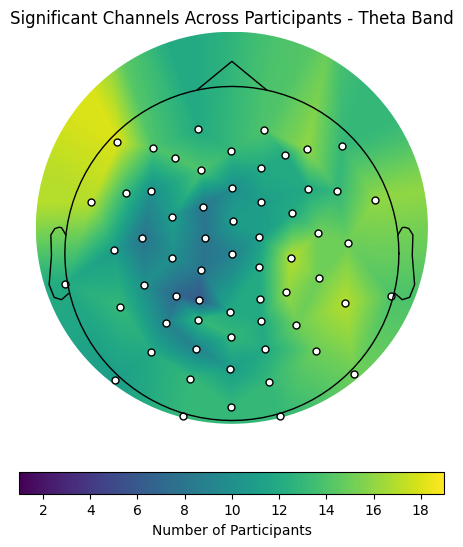

Creating topoplot for band: alpha


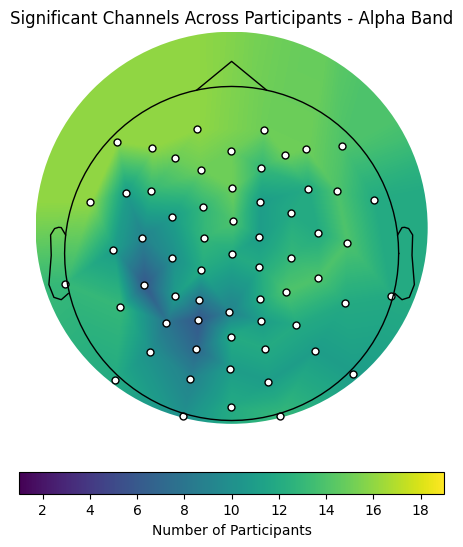

Creating topoplot for band: beta


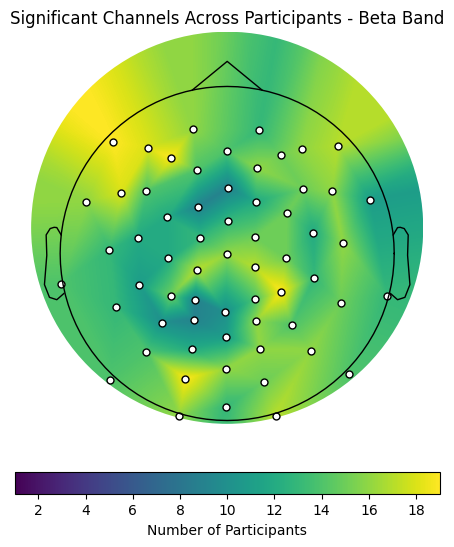

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Assuming the following variables are defined:
# freq_bands: dict containing frequency bands
# significant_channels_per_band: dict with significant channels per band and participant
# channel_names: list of channel names
# epochs_condition1: MNE Epochs object with channel info

# Step 1: Determine the global vmin and vmax across all frequency bands
all_counts = []

for band_name in freq_bands.keys():
    # Initialize channel counts for this band
    channel_counts = {ch: 0 for ch in channel_names}

    # Iterate over participants and count significant occurrences per channel
    for participant_id in significant_channels_per_band[band_name]:
        sig_channels = significant_channels_per_band[band_name][participant_id]
        for ch in sig_channels:
            if ch in channel_counts:
                channel_counts[ch] += 1
            else:
                print(f"Warning: Channel {ch} not found in channel names.")

    # Collect counts, excluding zeros
    counts = [count for count in channel_counts.values() if count > 0]
    all_counts.extend(counts)

# Define global vmin and vmax
global_vmin = 1  # Since counts start from 1
global_vmax = max(all_counts) if all_counts else 1  # Avoid max([]) error

print(f"Global vmin: {global_vmin}, Global vmax: {global_vmax}")

# Step 2: Create topoplots using the global color scale
for band_name in freq_bands.keys():
    print(f"Creating topoplot for band: {band_name}")

    # Initialize channel counts for this band
    channel_counts = {ch: 0 for ch in channel_names}

    # Iterate over participants and count significant occurrences per channel
    for participant_id in significant_channels_per_band[band_name]:
        sig_channels = significant_channels_per_band[band_name][participant_id]
        for ch in sig_channels:
            if ch in channel_counts:
                channel_counts[ch] += 1
            else:
                print(f"Warning: Channel {ch} not found in channel names.")

    # Create data array for topomap
    sig_data = np.array([channel_counts[ch] for ch in channel_names], dtype=float)

    # Handle channels that were never significant (set to NaN to exclude from color scaling)
    sig_data[sig_data == 0] = np.nan

    # Create an Evoked object for plotting
    info = epochs_condition1.info.copy()  # Use info from any participant (assuming consistent)
    info['bads'] = []  # Ensure no bad channels are marked
    evoked = mne.EvokedArray(sig_data[:, np.newaxis], info, tmin=0)

    # Plot topomap
    fig, ax = plt.subplots(figsize=(6, 6))

    im, cn = mne.viz.plot_topomap(
        sig_data,
        evoked.info,
        axes=ax,
        cmap='viridis',
        vlim=(global_vmin, global_vmax),  # Use global color scale
        sensors=True,
        res=256,
        names=None,
        sphere=(0.00, -0.02, 0.00, 0.13),
        show=False,
        image_interp='linear',
        contours=0,
        mask=np.isfinite(sig_data),
        mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                        linewidth=0, markersize=5)
    )

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Number of Participants')

    # Add title
    plt.title(f'Significant Channels Across Participants - {band_name.capitalize()} Band')

    # Show the plot
    plt.show()


In [30]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# List of valid participant IDs
valid_pids = [el for el in range(1, 32) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Initialize list to collect data for all participants
all_data = []

# Iterate over participants
for participant_id in valid_pids:
    print(f"Processing Participant {participant_id}...")
    try:
        # Load epochs for both conditions (ensure you have this function defined)
        epochs_condition1 = load_participant_epochs(participant_id, 'D')
        epochs_condition2 = load_participant_epochs(participant_id, 'ND')

        channels = epochs_condition1.ch_names  # List of channel names
        sfreq = epochs_condition1.info['sfreq']  # Sampling frequency

        data_c1 = epochs_condition1.get_data()  # Shape: (n_epochs, n_channels, n_times)
        data_c2 = epochs_condition2.get_data()

        # For each frequency band, compute average power per channel
        for band_name, (fmin, fmax) in freq_bands.items():
            # Compute PSDs for condition 1
            psds_c1, freqs = psd_array_multitaper(
                data_c1, sfreq, fmin=fmin, fmax=fmax, adaptive=True, normalization='full', verbose=False)
            psds_mean_c1 = psds_c1.mean(axis=-1)  # Average over frequencies
            psds_mean_c1 = psds_mean_c1.mean(axis=0)  # Average over epochs

            # Compute PSDs for condition 2
            psds_c2, freqs = psd_array_multitaper(
                data_c2, sfreq, fmin=fmin, fmax=fmax, adaptive=True, normalization='full', verbose=False)
            psds_mean_c2 = psds_c2.mean(axis=-1)  # Average over frequencies
            psds_mean_c2 = psds_mean_c2.mean(axis=0)  # Average over epochs

            # Combine data for normalization
            # power_values = np.concatenate([psds_mean_c1, psds_mean_c2])
            # Calculate mean and std for normalization
            # mean_power = np.mean(power_values)
            # std_power = np.std(power_values)

            # Normalize power values
            # Normalize power values for condition 1 (D)
            min_power_c1 = np.min(psds_mean_c1)
            max_power_c1 = np.max(psds_mean_c1)
            psds_mean_c1_norm = (psds_mean_c1 - min_power_c1) / (max_power_c1 - min_power_c1)

            # Normalize power values for condition 2 (ND)
            min_power_c2 = np.min(psds_mean_c2)
            max_power_c2 = np.max(psds_mean_c2)
            psds_mean_c2_norm = (psds_mean_c2 - min_power_c2) / (max_power_c2 - min_power_c2)


            # Collect data into a DataFrame
            df_c1 = pd.DataFrame({
                'participant': participant_id,
                'condition': 'D',
                'band': band_name,
                'channel': channels,
                'power': psds_mean_c1_norm
            })

            df_c2 = pd.DataFrame({
                'participant': participant_id,
                'condition': 'ND',
                'band': band_name,
                'channel': channels,
                'power': psds_mean_c2_norm
            })

            all_data.append(df_c1)
            all_data.append(df_c2)

    except Exception as e:
        print(f"Error processing Participant {participant_id}: {e}")

# Concatenate all data into a single DataFrame
data_df = pd.concat(all_data, ignore_index=True)

# Now perform statistical tests for each channel and band across all participants
results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        # Pivot the data to have one column per condition
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()
        if len(pivot_df) < 1:
            continue
        # Wilcoxon signed-rank test
        try:
            stat, p_value = wilcoxon(pivot_df['D'], pivot_df['ND'])
        except ValueError as e:
            stat, p_value = np.nan, np.nan
        results.append({
            'band': band_name,
            'channel': ch_name,
            'statistic': stat,
            'p_value': p_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('group_level_wilcoxon_results_normalized.csv', index=False)

print("Wilcoxon statistical analysis complete on normalized data.")

# Now perform Linear Mixed Effects models for each band and channel
lme_results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        if subset['condition'].nunique() < 2:
            continue
        # Fit LME model
        try:
            model = smf.mixedlm("power ~ condition", subset, groups=subset["participant"])
            result = model.fit()
            p_value = result.pvalues['condition[T.ND]']
            lme_results.append({
                'band': band_name,
                'channel': ch_name,
                'coef': result.params['condition[T.ND]'],
                'p_value': p_value
            })
        except Exception as e:
            lme_results.append({
                'band': band_name,
                'channel': ch_name,
                'coef': np.nan,
                'p_value': np.nan
            })

# Convert LME results to DataFrame
lme_results_df = pd.DataFrame(lme_results)

# Correct p-values for multiple comparisons
p_values = lme_results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
lme_results_df['p_value_corrected'] = pvals_corrected
lme_results_df['significant'] = reject

# Save LME results to CSV
lme_results_df.to_csv('group_level_lme_results_normalized.csv', index=False)

print("LME statistical analysis complete on normalized data.")

# Proceeding to plot topoplots or further analysis...


Processing Participant 1...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 2...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items a

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 3...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 4...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 6...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items a

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 7...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 8...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items 

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 9...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 10...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 11...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 12...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
137 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 15...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 18...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 19...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 21...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 22...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
114 matching events found
No baseline correction applied
0 projection i

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 23...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 24...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 25...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 26...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


102 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\ND3-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
390 matching events found
No baseline correction applied


C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 27...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection ite

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 28...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 29...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Processing Participant 30...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
109 matching events found
No baseline correction applied
0 projection it

C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_13700\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Wilcoxon statistical analysis complete on normalized data.


c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-p

LME statistical analysis complete on normalized data.


In [3]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import traceback

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# List of valid participant IDs
valid_pids = [el for el in range(1, 32) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Initialize list to collect data for all participants
all_data = []

# Iterate over participants
for participant_id in valid_pids:
    print(f"Processing Participant {participant_id}...")
    try:
        # Load epochs for both conditions
        epochs_condition1 = load_participant_epochs(participant_id, 'D')
        epochs_condition2 = load_participant_epochs(participant_id, 'ND')

        # Check if epochs are empty
        if len(epochs_condition1) == 0 or len(epochs_condition2) == 0:
            print(f"No epochs found for Participant {participant_id} in one of the conditions.")
            continue

        channels = epochs_condition1.ch_names  # List of channel names
        sfreq = epochs_condition1.info['sfreq']  # Sampling frequency

        data_c1 = epochs_condition1.get_data()  # Shape: (n_epochs, n_channels, n_times)
        data_c2 = epochs_condition2.get_data()

        # Normalize data before computing PSDs to range [-1, +1]
        n_epochs_c1, n_channels_c1, n_times_c1 = data_c1.shape
        n_epochs_c2, n_channels_c2, n_times_c2 = data_c2.shape

        normalized_data_c1 = np.zeros_like(data_c1)
        normalized_data_c2 = np.zeros_like(data_c2)

        for ch in range(n_channels_c1):
            # Flatten data over epochs and time
            data_ch_c1 = data_c1[:, ch, :].flatten()
            data_ch_c2 = data_c2[:, ch, :].flatten()

            # Compute min and max for data_c1 and data_c2 separately
            min_ch_c1 = data_ch_c1.min()
            max_ch_c1 = data_ch_c1.max()
            min_ch_c2 = data_ch_c2.min()
            max_ch_c2 = data_ch_c2.max()

            # Avoid division by zero
            denom_c1 = max_ch_c1 - min_ch_c1 if max_ch_c1 - min_ch_c1 != 0 else 1e-8
            denom_c2 = max_ch_c2 - min_ch_c2 if max_ch_c2 - min_ch_c2 != 0 else 1e-8

            # Normalize data_c1 for this channel to range [-1, +1]
            normalized_data_c1[:, ch, :] = 2 * ((data_c1[:, ch, :] - min_ch_c1) / denom_c1) - 1
            # Normalize data_c2 for this channel to range [-1, +1]
            normalized_data_c2[:, ch, :] = 2 * ((data_c2[:, ch, :] - min_ch_c2) / denom_c2) - 1

        # For each frequency band, compute average power per channel
        for band_name, (fmin, fmax) in freq_bands.items():
            # Compute PSDs for condition 1
            psds_c1, freqs = psd_array_multitaper(
                normalized_data_c1, sfreq, fmin=fmin, fmax=fmax, adaptive=True, normalization='full', verbose=False)
            psds_mean_c1 = psds_c1.mean(axis=-1)  # Average over frequencies
            psds_mean_c1 = psds_mean_c1.mean(axis=0)  # Average over epochs

            # Compute PSDs for condition 2
            psds_c2, freqs = psd_array_multitaper(
                normalized_data_c2, sfreq, fmin=fmin, fmax=fmax, adaptive=True, normalization='full', verbose=False)
            psds_mean_c2 = psds_c2.mean(axis=-1)  # Average over frequencies
            psds_mean_c2 = psds_mean_c2.mean(axis=0)  # Average over epochs

            # Collect data into a DataFrame
            df_c1 = pd.DataFrame({
                'participant': participant_id,
                'condition': 'D',
                'band': band_name,
                'channel': channels,
                'power': psds_mean_c1  # No normalization here
            })

            df_c2 = pd.DataFrame({
                'participant': participant_id,
                'condition': 'ND',
                'band': band_name,
                'channel': channels,
                'power': psds_mean_c2  # No normalization here
            })

            all_data.append(df_c1)
            all_data.append(df_c2)
            print(f"Data appended for Participant {participant_id}, Band {band_name}")

    except Exception as e:
        print(f"Error processing Participant {participant_id}: {e}")
        traceback.print_exc()

# Check if any data was collected
if not all_data:
    print("No data collected. Please check your data loading functions and data availability.")
    import sys
    sys.exit()

# Concatenate all data into a single DataFrame
data_df = pd.concat(all_data, ignore_index=True)
print("Data concatenated successfully.")

# Now perform statistical tests for each channel and band across all participants
results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        # Pivot the data to have one column per condition
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()
        if len(pivot_df) < 1:
            continue
        # Wilcoxon signed-rank test
        try:
            stat, p_value = wilcoxon(pivot_df['D'], pivot_df['ND'])
        except ValueError as e:
            stat, p_value = np.nan, np.nan
        results.append({
            'band': band_name,
            'channel': ch_name,
            'statistic': stat,
            'p_value': p_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('group_level_wilcoxon_results_normalized_signals_-1_to_1.csv', index=False)
print("Wilcoxon statistical analysis complete on data with normalized signals (-1 to +1).")

# Now perform Linear Mixed Effects models for each band and channel
lme_results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        if subset['condition'].nunique() < 2:
            continue
        # Fit LME model
        try:
            model = smf.mixedlm("power ~ condition", subset, groups=subset["participant"])
            result = model.fit()
            p_value = result.pvalues.get('condition[T.ND]', np.nan)
            lme_results.append({
                'band': band_name,
                'channel': ch_name,
                'coef': result.params.get('condition[T.ND]', np.nan),
                'p_value': p_value
            })
        except Exception as e:
            lme_results.append({
                'band': band_name,
                'channel': ch_name,
                'coef': np.nan,
                'p_value': np.nan
            })
            print(f"Error fitting LME model for Band {band_name}, Channel {ch_name}: {e}")
            traceback.print_exc()

# Convert LME results to DataFrame
lme_results_df = pd.DataFrame(lme_results)

# Correct p-values for multiple comparisons
p_values = lme_results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
lme_results_df['p_value_corrected'] = pvals_corrected
lme_results_df['significant'] = reject

# Save LME results to CSV
lme_results_df.to_csv('group_level_lme_results_normalized_signals_-1_to_1.csv', index=False)
print("LME statistical analysis complete on data with normalized signals (-1 to +1).")

# Proceeding to plot topoplots or further analysis...


Processing Participant 1...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 1, Band theta
Data appended for Participant 1, Band alpha
Data appended for Participant 1, Band beta
Processing Participant 2...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 2, Band theta
Data appended for Participant 2, Band alpha
Data appended for Participant 2, Band beta
Processing Participant 3...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 C

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 3, Band theta
Data appended for Participant 3, Band alpha
Data appended for Participant 3, Band beta
Processing Participant 4...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 4, Band theta
Data appended for Participant 4, Band alpha
Data appended for Participant 4, Band beta
Processing Participant 6...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 6, Band theta
Data appended for Participant 6, Band alpha
Data appended for Participant 6, Band beta
Processing Participant 7...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 C

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 7, Band theta
Data appended for Participant 7, Band alpha
Data appended for Participant 7, Band beta
Processing Participant 8...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 8, Band theta
Data appended for Participant 8, Band alpha
Data appended for Participant 8, Band beta
Processing Participant 9...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 C

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 9, Band theta
Data appended for Participant 9, Band alpha
Data appended for Participant 9, Band beta
Processing Participant 10...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 10, Band theta
Data appended for Participant 10, Band alpha
Data appended for Participant 10, Band beta
Processing Participant 11...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 11, Band theta
Data appended for Participant 11, Band alpha
Data appended for Participant 11, Band beta
Processing Participant 12...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 12, Band theta
Data appended for Participant 12, Band alpha
Data appended for Participant 12, Band beta
Processing Participant 15...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 15, Band theta
Data appended for Participant 15, Band alpha
Data appended for Participant 15, Band beta
Processing Participant 18...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 18, Band theta
Data appended for Participant 18, Band alpha
Data appended for Participant 18, Band beta
Processing Participant 19...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 19, Band theta
Data appended for Participant 19, Band alpha
Data appended for Participant 19, Band beta
Processing Participant 21...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 21, Band theta
Data appended for Participant 21, Band alpha
Data appended for Participant 21, Band beta
Processing Participant 22...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 22, Band theta
Data appended for Participant 22, Band alpha
Data appended for Participant 22, Band beta
Processing Participant 23...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 23, Band theta
Data appended for Participant 23, Band alpha
Data appended for Participant 23, Band beta
Processing Participant 24...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 24, Band theta
Data appended for Participant 24, Band alpha
Data appended for Participant 24, Band beta
Processing Participant 25...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 25, Band theta
Data appended for Participant 25, Band alpha
Data appended for Participant 25, Band beta
Processing Participant 26...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 26, Band theta
Data appended for Participant 26, Band alpha
Data appended for Participant 26, Band beta
Processing Participant 27...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 27, Band theta
Data appended for Participant 27, Band alpha
Data appended for Participant 27, Band beta
Processing Participant 28...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 28, Band theta
Data appended for Participant 28, Band alpha
Data appended for Participant 28, Band beta
Processing Participant 29...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 29, Band theta
Data appended for Participant 29, Band alpha
Data appended for Participant 29, Band beta
Processing Participant 30...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 30, Band theta
Data appended for Participant 30, Band alpha
Data appended for Participant 30, Band beta
Data concatenated successfully.
Wilcoxon statistical analysis complete on data with normalized signals (-1 to +1).


c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-p

LME statistical analysis complete on data with normalized signals (-1 to +1).


c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-p

Processing Participant 1...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 1, Band theta
Data appended for Participant 1, Band alpha
Data appended for Participant 1, Band beta
Processing Participant 2...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P2\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 2, Band theta
Data appended for Participant 2, Band alpha
Data appended for Participant 2, Band beta
Processing Participant 3...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P3\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 C

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 3, Band theta
Data appended for Participant 3, Band alpha
Data appended for Participant 3, Band beta
Processing Participant 4...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P4\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 4, Band theta
Data appended for Participant 4, Band alpha
Data appended for Participant 4, Band beta
Processing Participant 6...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P6\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 6, Band theta
Data appended for Participant 6, Band alpha
Data appended for Participant 6, Band beta
Processing Participant 7...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P7\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 C

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 7, Band theta
Data appended for Participant 7, Band alpha
Data appended for Participant 7, Band beta
Processing Participant 8...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P8\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CT

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Data appended for Participant 8, Band theta
Data appended for Participant 8, Band alpha
Data appended for Participant 8, Band beta
Processing Participant 9...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P9\D2-epo.fif ...
    Found the data of interest:
        t =       0.0

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 9, Band theta
Data appended for Participant 9, Band alpha
Data appended for Participant 9, Band beta
Processing Participant 10...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P10\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 10, Band theta
Data appended for Participant 10, Band alpha
Data appended for Participant 10, Band beta
Processing Participant 11...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P11\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 11, Band theta
Data appended for Participant 11, Band alpha
Data appended for Participant 11, Band beta
Processing Participant 12...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P12\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 12, Band theta
Data appended for Participant 12, Band alpha
Data appended for Participant 12, Band beta
Processing Participant 15...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P15\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 15, Band theta
Data appended for Participant 15, Band alpha
Data appended for Participant 15, Band beta
Processing Participant 18...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P18\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 18, Band theta
Data appended for Participant 18, Band alpha
Data appended for Participant 18, Band beta
Processing Participant 19...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P19\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 19, Band theta
Data appended for Participant 19, Band alpha
Data appended for Participant 19, Band beta
Processing Participant 21...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P21\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 21, Band theta
Data appended for Participant 21, Band alpha
Data appended for Participant 21, Band beta
Processing Participant 22...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P22\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 22, Band theta
Data appended for Participant 22, Band alpha
Data appended for Participant 22, Band beta
Processing Participant 23...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P23\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 23, Band theta
Data appended for Participant 23, Band alpha
Data appended for Participant 23, Band beta
Processing Participant 24...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P24\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 24, Band theta
Data appended for Participant 24, Band alpha
Data appended for Participant 24, Band beta
Processing Participant 25...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P25\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 25, Band theta
Data appended for Participant 25, Band alpha
Data appended for Participant 25, Band beta
Processing Participant 26...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P26\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 26, Band theta
Data appended for Participant 26, Band alpha
Data appended for Participant 26, Band beta
Processing Participant 27...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P27\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 27, Band theta
Data appended for Participant 27, Band alpha
Data appended for Participant 27, Band beta
Processing Participant 28...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P28\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 28, Band theta
Data appended for Participant 28, Band alpha
Data appended for Participant 28, Band beta
Processing Participant 29...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P29\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
    

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 29, Band theta
Data appended for Participant 29, Band alpha
Data appended for Participant 29, Band beta
Processing Participant 30...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P30\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
     

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Data appended for Participant 30, Band theta
Data appended for Participant 30, Band alpha
Data appended for Participant 30, Band beta
Data concatenated successfully.
Starting statistical analyses...
Wilcoxon statistical analysis complete on data without normalization.
Starting Linear Mixed Effects (LME) models...


c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\erangad\AppData\Local\anaconda3\envs\eeg\lib\site-p

LME statistical analysis complete on data without normalization.
Generating PSD topographical plots for a single participant...
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices availa

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


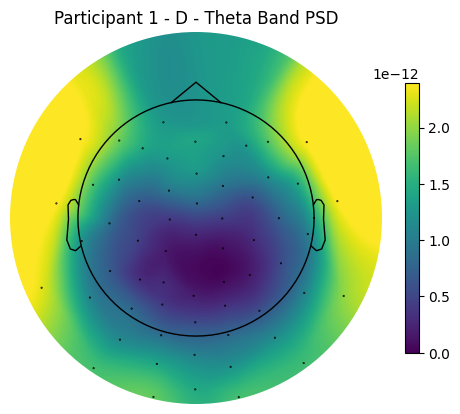

Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


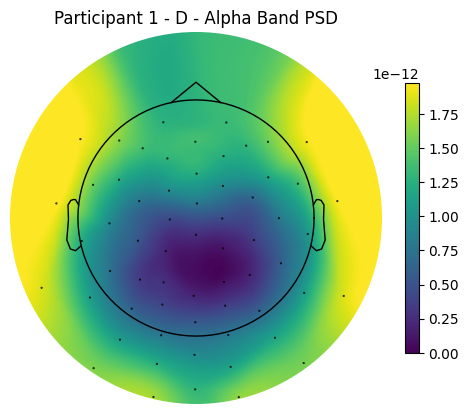

Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


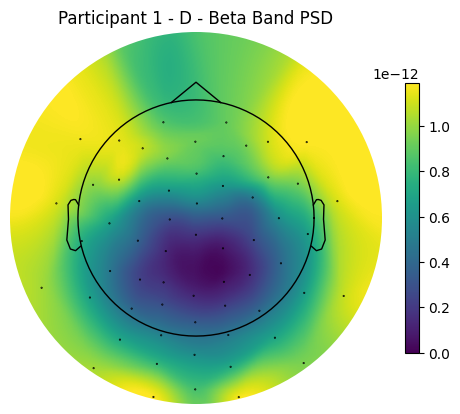

Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


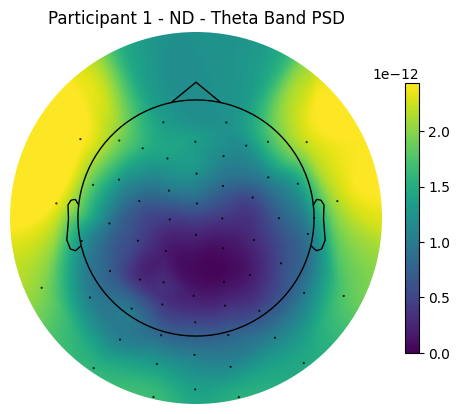

Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


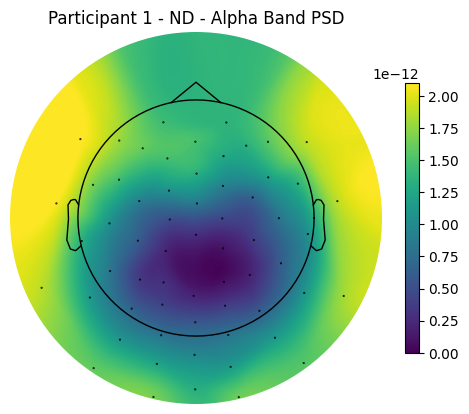

Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\ND2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users

C:\Users\erangad\AppData\Local\Temp\ipykernel_17296\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


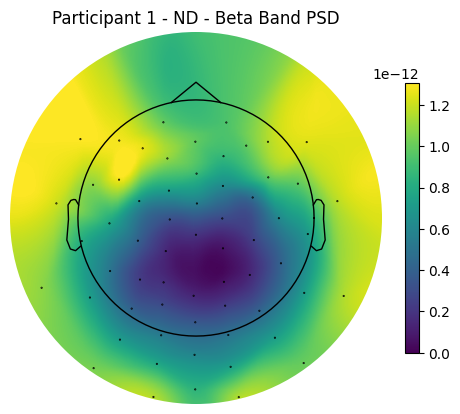

PSD topographical plots generation complete.


In [3]:
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_multitaper
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import traceback

# ------------------------------
# Function Definitions
# ------------------------------

def plot_psd_topomap(participant_id, condition, band_name, data_df, epochs):
    """
    Plots the PSD topomap for a specified participant, condition, and frequency band.

    Parameters:
    - participant_id: int, ID of the participant
    - condition: str, condition label ('D' or 'ND')
    - band_name: str, frequency band name ('theta', 'alpha', 'beta')
    - data_df: pandas DataFrame, concatenated data
    - epochs: mne.Epochs object, for channel locations
    """
    # Subset data for the specified participant, condition, and band
    subset = data_df[
        (data_df['participant'] == participant_id) &
        (data_df['condition'] == condition) &
        (data_df['band'] == band_name)
    ]

    if subset.empty:
        print(f"No data found for Participant {participant_id}, Condition {condition}, Band {band_name}.")
        return

    # Get PSD values per channel
    psd_values = subset.set_index('channel')['power']

    # Ensure the order of channels matches the epochs info
    psd_values = psd_values.reindex(epochs.ch_names)

    # Handle any missing channels
    if psd_values.isnull().any():
        print(f"Warning: Missing PSD values for some channels in Participant {participant_id}, Condition {condition}, Band {band_name}.")
        psd_values = psd_values.fillna(psd_values.mean())

    # Get channel positions from the epochs info
    info = epochs.info

    # Create the topomap plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    im, cn = mne.viz.plot_topomap(
        psd_values.values,
        info,
        axes=ax,
        show=False,
        cmap='viridis',
        contours=0
    )
    ax.set_title(f'Participant {participant_id} - {condition} - {band_name.capitalize()} Band PSD')
    plt.colorbar(im, ax=ax, shrink=0.7)
    plt.show()

# ------------------------------
# Main Data Processing
# ------------------------------

# Frequency bands to analyze
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# List of valid participant IDs
valid_pids = [el for el in range(1, 32) if el not in [5, 13, 14, 16, 17, 20, 31]]

# Initialize list to collect data for all participants
all_data = []

# Iterate over participants
for participant_id in valid_pids:
    print(f"Processing Participant {participant_id}...")
    try:
        # Load epochs for both conditions
        epochs_condition1 = load_participant_epochs(participant_id, 'D')
        epochs_condition2 = load_participant_epochs(participant_id, 'ND')

        # Check if epochs are empty
        if len(epochs_condition1) == 0 or len(epochs_condition2) == 0:
            print(f"No epochs found for Participant {participant_id} in one of the conditions.")
            continue

        channels = epochs_condition1.ch_names  # List of channel names
        sfreq = epochs_condition1.info['sfreq']  # Sampling frequency

        data_c1 = epochs_condition1.get_data()  # Shape: (n_epochs, n_channels, n_times)
        data_c2 = epochs_condition2.get_data()

        # No normalization; proceed to compute PSDs directly

        # For each frequency band, compute average power per channel
        for band_name, (fmin, fmax) in freq_bands.items():
            # Compute PSDs for condition 1
            psds_c1, freqs = psd_array_multitaper(
                data_c1, sfreq, fmin=fmin, fmax=fmax, adaptive=True, normalization='full', verbose=False)
            psds_mean_c1 = psds_c1.mean(axis=-1)  # Average over frequencies
            psds_mean_c1 = psds_mean_c1.mean(axis=0)  # Average over epochs

            # Compute PSDs for condition 2
            psds_c2, freqs = psd_array_multitaper(
                data_c2, sfreq, fmin=fmin, fmax=fmax, adaptive=True, normalization='full', verbose=False)
            psds_mean_c2 = psds_c2.mean(axis=-1)  # Average over frequencies
            psds_mean_c2 = psds_mean_c2.mean(axis=0)  # Average over epochs

            # Collect data into a DataFrame
            df_c1 = pd.DataFrame({
                'participant': participant_id,
                'condition': 'D',
                'band': band_name,
                'channel': channels,
                'power': psds_mean_c1  # No normalization here
            })

            df_c2 = pd.DataFrame({
                'participant': participant_id,
                'condition': 'ND',
                'band': band_name,
                'channel': channels,
                'power': psds_mean_c2  # No normalization here
            })

            all_data.append(df_c1)
            all_data.append(df_c2)
            print(f"Data appended for Participant {participant_id}, Band {band_name}")

    except Exception as e:
        print(f"Error processing Participant {participant_id}: {e}")
        traceback.print_exc()

# Check if any data was collected
if not all_data:
    print("No data collected. Please check your data loading functions and data availability.")
    import sys
    sys.exit()

# Concatenate all data into a single DataFrame
data_df = pd.concat(all_data, ignore_index=True)
print("Data concatenated successfully.")

# ------------------------------
# Statistical Analyses
# ------------------------------
print("Starting statistical analyses...")

# ------------------------------
# Wilcoxon Signed-Rank Test
# ------------------------------
results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        # Pivot the data to have one column per condition
        pivot_df = subset.pivot(index='participant', columns='condition', values='power').dropna()
        if len(pivot_df) < 1:
            continue
        # Wilcoxon signed-rank test
        try:
            stat, p_value = wilcoxon(pivot_df['D'], pivot_df['ND'])
        except ValueError as e:
            stat, p_value = np.nan, np.nan
        results.append({
            'band': band_name,
            'channel': ch_name,
            'statistic': stat,
            'p_value': p_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons
p_values = results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['significant'] = reject

# Save results to CSV
results_df.to_csv('group_level_wilcoxon_results_no_normalization.csv', index=False)
print("Wilcoxon statistical analysis complete on data without normalization.")

# ------------------------------
# Linear Mixed Effects Models
# ------------------------------
print("Starting Linear Mixed Effects (LME) models...")

lme_results = []
for band_name in freq_bands.keys():
    for ch_name in channels:
        # Subset data for this band and channel
        subset = data_df[(data_df['band'] == band_name) & (data_df['channel'] == ch_name)]
        if subset['condition'].nunique() < 2:
            continue
        # Fit LME model
        try:
            model = smf.mixedlm("power ~ condition", subset, groups=subset["participant"])
            result = model.fit()
            p_value = result.pvalues.get('condition[T.ND]', np.nan)
            lme_results.append({
                'band': band_name,
                'channel': ch_name,
                'coef': result.params.get('condition[T.ND]', np.nan),
                'p_value': p_value
            })
        except Exception as e:
            lme_results.append({
                'band': band_name,
                'channel': ch_name,
                'coef': np.nan,
                'p_value': np.nan
            })
            print(f"Error fitting LME model for Band {band_name}, Channel {ch_name}: {e}")
            traceback.print_exc()

# Convert LME results to DataFrame
lme_results_df = pd.DataFrame(lme_results)

# Correct p-values for multiple comparisons
p_values = lme_results_df['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
lme_results_df['p_value_corrected'] = pvals_corrected
lme_results_df['significant'] = reject

# Save LME results to CSV
lme_results_df.to_csv('group_level_lme_results_no_normalization.csv', index=False)
print("LME statistical analysis complete on data without normalization.")

# ------------------------------
# PSD Topographical Plots for One Participant
# ------------------------------
print("Generating PSD topographical plots for a single participant...")

# Function to plot PSD topomap is already defined above

# Specify the participant, conditions, and bands you want to plot
participant_to_plot = 1  # Change to the desired participant ID
conditions_to_plot = ['D', 'ND']  # List of conditions to plot
bands_to_plot = ['theta', 'alpha', 'beta']  # List of frequency bands to plot

for condition in conditions_to_plot:
    for band in bands_to_plot:
        # Reload epochs for the specified participant and condition to get channel info
        try:
            epochs_to_plot = load_participant_epochs(participant_to_plot, condition)
        except FileNotFoundError as e:
            print(f"Cannot plot topomap for Participant {participant_to_plot}, Condition {condition}: {e}")
            epochs_to_plot = None

        if epochs_to_plot is not None:
            # Call the plotting function
            plot_psd_topomap(
                participant_id=participant_to_plot,
                condition=condition,
                band_name=band,
                data_df=data_df,
                epochs=epochs_to_plot
            )
        else:
            print(f"Cannot plot topomap without valid epochs for Participant {participant_to_plot}, Condition {condition}.")

print("PSD topographical plots generation complete.")


In [4]:
normalized_data_c1

array([[[-2.17366765e-01, -1.90669793e-01, -1.68244912e-01, ...,
          1.07451993e-01,  1.86330468e-01,  2.59827990e-01],
        [-2.57895415e-01, -2.25005877e-01, -1.45655825e-01, ...,
          2.42585348e-01,  2.91630437e-01,  3.07746859e-01],
        [-4.38706398e-01, -4.00818687e-01, -3.22927977e-01, ...,
          1.38298693e-01,  1.77384171e-01,  2.09078860e-01],
        ...,
        [ 3.94176061e-01,  3.88654835e-01,  3.59369493e-01, ...,
         -5.83241899e-02, -4.15208456e-03,  2.41100865e-02],
        [ 3.67228445e-01,  3.53563486e-01,  3.48670694e-01, ...,
         -8.72743537e-02, -9.71102032e-02, -1.74450646e-01],
        [ 2.33663475e-01,  1.88625367e-01,  1.68415641e-01, ...,
         -2.14424963e-01, -2.47685482e-01, -3.18668182e-01]],

       [[ 3.57420646e-01,  4.86716821e-01,  6.19438398e-01, ...,
         -5.37090219e-01, -4.68701167e-01, -2.79562555e-01],
        [ 3.13493461e-01,  3.29112889e-01,  3.55833179e-01, ...,
         -3.36740214e-01, -2.93097091e

In [39]:
all_data

[]

C:\Users\erangad\AppData\Local\Temp\ipykernel_17376\1363515862.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust for color bar


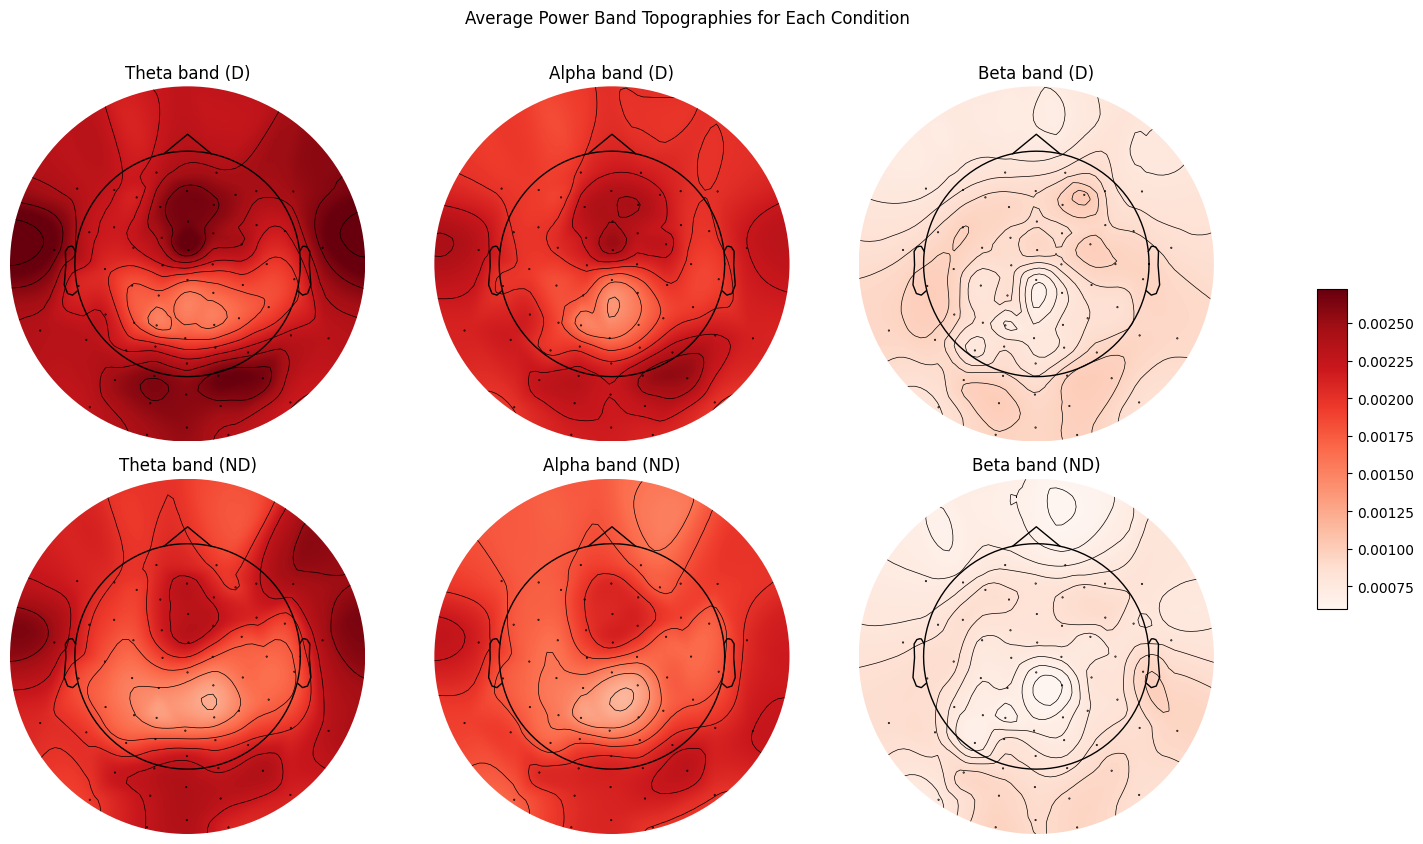

In [5]:
# Set up the plot grid for the topographies: 3 bands * 2 conditions = 6 plots in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
conditions = ['D', 'ND']

# Initialize variables to track the global min and max power values
global_min = np.inf
global_max = -np.inf

# First pass to determine global min and max values for the color scale
for idx, band_name in enumerate(freq_bands.keys()):
    for cond_idx, condition in enumerate(conditions):
        # Subset the data for this condition and band
        subset = data_df[(data_df['band'] == band_name) & (data_df['condition'] == condition)]
        
        # Calculate the mean power across participants for each channel
        mean_power = subset.groupby('channel')['power'].mean().reindex(channels).values
        
        # Update global min and max
        global_min = min(global_min, mean_power.min())
        global_max = max(global_max, mean_power.max())

# Second pass to create the plots using the determined global color limits
for idx, band_name in enumerate(freq_bands.keys()):
    for cond_idx, condition in enumerate(conditions):
        # Subset the data for this condition and band
        subset = data_df[(data_df['band'] == band_name) & (data_df['condition'] == condition)]
        
        # Calculate the mean power across participants for each channel
        mean_power = subset.groupby('channel')['power'].mean().reindex(channels).values

        # Plot the topomap for this band and condition
        ax = axes[cond_idx, idx]
        im, _ = mne.viz.plot_topomap(mean_power, epochs_condition1.info, axes=ax, show=False, vlim=(global_min, global_max))
        ax.set_title(f'{band_name.capitalize()} band ({condition})')

# Add a global color bar to the right of the plots
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar_ax.set_label('Normalized Power')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust for color bar
plt.suptitle('Average Power Band Topographies for Each Condition', y=1.05)
plt.show()


C:\Users\erangad\AppData\Local\Temp\ipykernel_12836\2233978244.py:53: RuntimeWarning: All-NaN slice encountered
  cmap='RdBu_r', vlim=(-np.nanmax(np.abs(power_diff_sig_only)),np.nanmax(np.abs(power_diff_sig_only))),


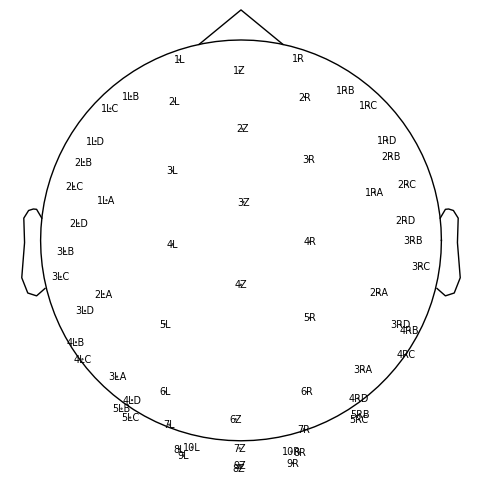

C:\Users\erangad\AppData\Local\Temp\ipykernel_12836\2233978244.py:56: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im, ax=ax)


<Figure size 640x480 with 0 Axes>

C:\Users\erangad\AppData\Local\Temp\ipykernel_12836\2233978244.py:53: RuntimeWarning: All-NaN slice encountered
  cmap='RdBu_r', vlim=(-np.nanmax(np.abs(power_diff_sig_only)),np.nanmax(np.abs(power_diff_sig_only))),


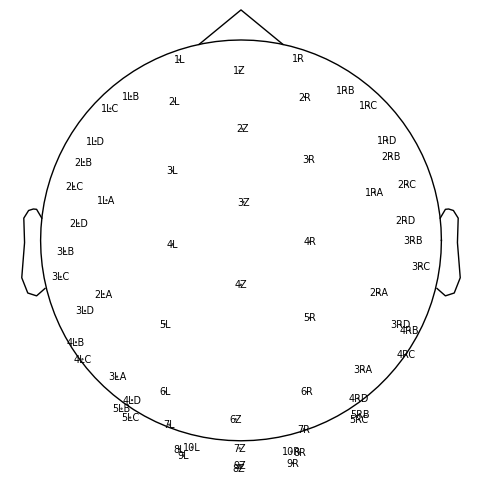

C:\Users\erangad\AppData\Local\Temp\ipykernel_12836\2233978244.py:56: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im, ax=ax)


<Figure size 640x480 with 0 Axes>

C:\Users\erangad\AppData\Local\Temp\ipykernel_12836\2233978244.py:53: RuntimeWarning: All-NaN slice encountered
  cmap='RdBu_r', vlim=(-np.nanmax(np.abs(power_diff_sig_only)),np.nanmax(np.abs(power_diff_sig_only))),


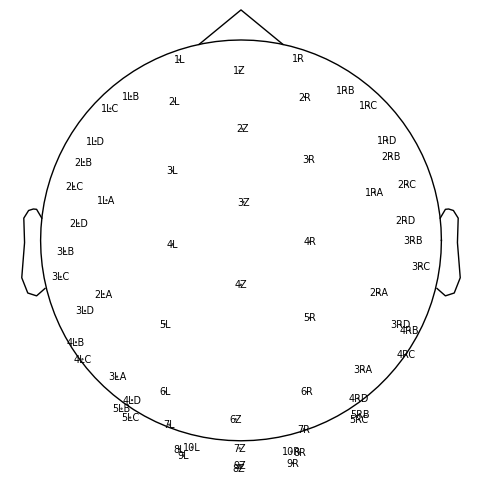

C:\Users\erangad\AppData\Local\Temp\ipykernel_12836\2233978244.py:56: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im, ax=ax)


<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from mne.channels import make_standard_montage

# Assuming 'data_df' is the DataFrame containing the normalized power data
# and 'results_df' or 'lme_results_df' contains the statistical results

# Load the standard EEG montage for channel locations
montage = epochs_condition1.get_montage()

# List of frequency bands
freq_bands = ['theta', 'alpha', 'beta']

# Get the list of channels
channels = data_df['channel'].unique().tolist()

# Create an info object for the channels
info = mne.create_info(ch_names=channels, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Iterate over frequency bands
for band in freq_bands:
    # Subset data for the current band
    band_data = data_df[data_df['band'] == band]
    
    # Calculate the mean power difference between conditions for each channel
    mean_power = band_data.groupby(['channel', 'condition'])['power'].mean().unstack()
    mean_power['diff'] = mean_power['D'] - mean_power['ND']
    
    # Prepare the data for topomap
    power_diff = mean_power['diff'].reindex(channels).values
    
    # Get statistical significance from results_df
    # Here, we use 'results_df' from the Wilcoxon test; you can also use 'lme_results_df'
    band_results = results_df[results_df['band'] == band]
    # Create a mask for significant channels
    sig_channels = band_results[band_results['significant'] == True]['channel'].values
    sig_mask = np.isin(channels, sig_channels)
    
    # Set power differences of non-significant channels to NaN
    power_diff_sig_only = np.where(sig_mask, power_diff, np.nan)
    
    # Get the positions of the channels
    pos = [info['chs'][info.ch_names.index(ch)]['loc'][:2] for ch in channels]
    pos = np.array(pos)
    
    # Plot the topomap with only significant channels
    fig, ax = plt.subplots(figsize=(8, 6))
    im, cn = plot_topomap(power_diff_sig_only, pos, names=channels,
                          cmap='RdBu_r', vlim=(-np.nanmax(np.abs(power_diff_sig_only)),np.nanmax(np.abs(power_diff_sig_only))),
                          axes=ax)
    ax.set_title(f'{band.capitalize()} Band Power Difference (D - ND)\nSignificant Channels Only')
    plt.colorbar(im, ax=ax)
    plt.show()
